RB  
Intensive Data Science II  
Ms. Pan    
1/17/25
# Q2 Final Project - World Commuter Rail Systems

This dataset contains statistics of every single commuter and suburban rail system taken from a Wikipedia table using the Google sheets function IMPORTHTML(). Once imported, the data was cleaned and placed into pycharm for analysis. The first chart shows that Myanmar(Burma) has extremely high density, with $0.85$ stops every kilometer! Upon further research, the main system is in Yangon, the largest city in Myanmar, and one that recently began construction on a new metro system. It will replace the old commuter rail system that the city has outgrown. The second plot contains two logarithmic scattergrams comparing commuter rail systems between Europe and Asia (top subplot) and the rest of the world (bottom subplot). The scattergrams show that Europe and Asia stand out in terms of higher daily ridership and longer rail lengths compared to other continents. The final plot is a bar plot that further demonstrates Asia's dominance in the commuter rail and transit world as it as a total data ridership of almost 60 million riders!

### Table of Contents
[Dataset](#Dataset)  
[Station Density Choropleth](#Choropleth-Commuter-Rail-Station-Density-Plot)  
[Daily Ridership vs. Length Scatterplots](#Length-vs.-Daily-Ridership)   
[Daily Ridership by Country](#Daily-Ridership-by-Continent)  
[Conclusion](#Conclusion)




In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import pycountry as pc
plt.style.use('ggplot')

### Dataset

In [3]:
df = pd.read_csv('metro_systems - WorldCommuter.csv')
df.head()

,City or area,City,Country,Name,Lines,Stations,Length (km),Daily ridership,Frequency
0,Algiers,Algiers,Algeria,Algiers RER,4.0,33.0,126.5,91000.0,0.2608695652
1,Buenos Aires,Buenos Aires,Argentina,Buenos Aires Metropolitan Area Rail Network,8.0,224.0,815.0,1400000.0,0.2748466258
2,Córdoba,Córdoba,Argentina,Tren de las Sierras,1.0,17.0,150.8,1388.0,0.1127320955
3,La Plata,La Plata,Argentina,University train of La Plata,1.0,7.0,4.6,7559.0,1.52173913
4,Neuquén - Cipolletti,Neuquén,Argentina,Tren del Valle,1.0,5.0,21.0,400.0,0.2380952381


In [4]:
def iso3_code(name):
    try:
        return pc.countries.lookup(name).alpha_3
    except LookupError:
        return None
    
df["ISO3"] = df["Country"].apply(iso3_code)   

In [5]:
def country(name):
    return pc.countries.lookup(name).name

# https://www.geeksforgeeks.org/working-with-missing-data-in-pandas/
fix = ["Lines", "Stations", "Length (km)", "Daily ridership"]
df[fix] = df[fix].fillna(0)

filtered_df = df[(df["Length (km)"] > 0) & (df["Stations"] > 0)]

totals = ["Lines", "Stations", "Length (km)", "Daily ridership"]
country_df = filtered_df.groupby("ISO3", as_index=False)[totals].sum()

country_df["Country"] = country_df["ISO3"].apply(country)

country_df["Density (Stations/km)"] = country_df["Stations"] / country_df["Length (km)"]
country_df["Density (Stations/km)"] = country_df["Density (Stations/km)"].fillna(0)


## Choropleth Commuter Rail Station Density Plot
This map visualizes the density of commuter rail stations (stations per kilometer) by country. Japan and Hungary, stand out with high densities due to their rail networks that work more like metro systems. In contrast, North and South America generally have lower densities. Russia was not displayed due to missing data, however, other grey regions display countries without commuter rail systems, with central Africa having few systems. 

In [6]:
# Choropleth
fig = px.choropleth(country_df, locations="ISO3", color="Density (Stations/km)", color_continuous_scale="Thermal", title="Commuter Rail Station Density", hover_name="Country")

fig.update_layout(
    margin=dict(t=80, b=20), 
    width=900, 
    height=400,
)


In [7]:
import pycountry_convert as pcc
# https://stackoverflow.com/questions/55910004/get-continent-name-from-country-using-pycountry
def country_to_continent(country_name):
    country_alpha2 = pcc.country_name_to_country_alpha2(country_name)
    country_continent_code = pcc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pcc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name
continent_df = filtered_df
continent_df["Continent"] = filtered_df["Country"].apply(country_to_continent)
continent_df.to_csv("Continent.csv", index=False)

ModuleNotFoundError: No module named 'pycountry_convert'

## Length vs. Daily Ridership
This plot compares the length of commuter rail networks (in kilometers) with daily ridership across continents. The first subplot contains Europe and Asia, and the second has the rest of the world. Systems with higher ridership tend to have longer networks, mostly in Europe and Asia. JR East, Japan’s largest rail operator, stands out as a significant outlier with exceptionally high daily ridership compared to other systems, due to the efficiency and popularity of its dense commuter rail network. Other continents show a wider scatter, meaning more ridership variation compared to the network's length.

The legend also contains a calculated $R^2$ value for the relationship between length and daily ridership. North America’s relatively low $R^2$ of $0.53$ shows the varied use its commuter rail systems.

In [15]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
from scipy.stats import linregress

continent_df = continent_df[continent_df["Daily ridership"] > 0]
europe = continent_df[continent_df["Continent"] == "Europe"]
asia = continent_df[continent_df["Continent"] == "Asia"]
north_america = continent_df[continent_df["Continent"] == "North America"]
south_america = continent_df[continent_df["Continent"] == "South America"]
africa = continent_df[continent_df["Continent"] == "Africa"]
oceania = continent_df[continent_df["Continent"] == "Oceania"]

def calculate_r2(x, y):
    if len(x) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        return r_value**2
    else:
        return None
    
europe_r2 = calculate_r2(np.log(europe["Daily ridership"]), europe["Length (km)"])
asia_r2 = calculate_r2(np.log(asia["Daily ridership"]), asia["Length (km)"])
north_america_r2 = calculate_r2(np.log(north_america["Daily ridership"]), north_america["Length (km)"])
south_america_r2 = calculate_r2(np.log(south_america["Daily ridership"]), south_america["Length (km)"])
africa_r2 = calculate_r2(np.log(africa["Daily ridership"]), africa["Length (km)"])
oceania_r2 = calculate_r2(np.log(oceania["Daily ridership"]), oceania["Length (km)"])

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=("Europe and Asia", "Rest of World"), vertical_spacing=0.05)

fig.append_trace(go.Scatter(x=europe["Daily ridership"], y=europe["Length (km)"], mode="markers", hovertext=europe["Name"], name=f"Europe (R^2: {europe_r2:.2f})"), row=1, col=1)
fig.append_trace(go.Scatter(x=asia["Daily ridership"], y=asia["Length (km)"], mode="markers", hovertext=asia["Name"], name=f"Asia (R^2: {asia_r2:.2f})"), row=1, col=1)
fig.append_trace(go.Scatter(x=north_america["Daily ridership"], y=north_america["Length (km)"], mode="markers", hovertext=north_america["Name"], name=f"North America (R^2: {north_america_r2:.2f})"), row=2, col=1)
fig.append_trace(go.Scatter(x=south_america["Daily ridership"], y=south_america["Length (km)"], mode="markers", hovertext=south_america["Name"], name=f"South America (R^2: {south_america_r2:.2f})"), row=2, col=1)
fig.append_trace(go.Scatter(x=africa["Daily ridership"], y=africa["Length (km)"], mode="markers", hovertext=africa["Name"], name=f"Africa (R^2: {africa_r2:.2f})"), row=2, col=1)
fig.append_trace(go.Scatter(x=oceania["Daily ridership"], y=oceania["Length (km)"], mode="markers", hovertext=oceania["Name"], name=f"Oceania (R^2: {oceania_r2:.2f})"), row=2, col=1)

fig.update_layout(title_text="Length (km) vs. Daily Ridership of Worldwide Commuter Rail Systems",autosize=False,width=800,height=700,)
fig.update_xaxes(title_text="Daily Ridership (log scale)", type="log", row=2, col=1)
fig.update_yaxes(title_text="Length (km)", row=1, col=1)
fig.update_yaxes(title_text="Length (km)", row=2, col=1)

fig.update_xaxes(type="log")
fig.show()


## Daily Ridership by Continent
The bar chart illustrates daily ridership across continents, highlighting Asia as the clear leader with almost 60 million riders per day, greatly surpassing all other regions. Europe ranks second, while other continents like South America, North America, Oceania, and Africa show significantly lower daily ridership, emphasizing the disparity in the scale and usage of commuter rail systems worldwide.

Text(0.5, 0.98, 'Daily Ridership by Continent')

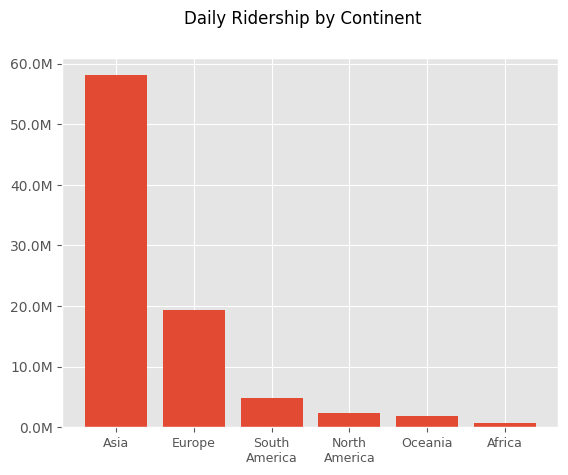

In [16]:
import matplotlib.ticker as mtick
grouped_data = continent_df.groupby("Continent", as_index=False)["Daily ridership"].sum()
grouped_data = grouped_data.sort_values(by="Daily ridership", ascending=False)
grouped_data["Continent"] = grouped_data["Continent"].str.replace(" ", "\n")

plt.bar(grouped_data["Continent"], grouped_data["Daily ridership"])

plt.xticks(size = 9)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.suptitle("Daily Ridership by Continent")


## Conclusion
Overall, the data shows that Asia and Europe dominate the commuter rail world, both in terms of daily ridership and system length. Interestingly, Europe and Asia also have the lowest $R^2$ values, both around $0.27$, which means that the countries in these continents do not entirely have the same faith in commuter rail. Commuter rail is an evolving mode of transportation, shaped by the unique economic, cultural, and urban dynamics of each country, reflecting the varied priorities and challenges within these regions. 